# Create a dataset of small boxes of the original stamp

The aim of this notebook is to slice the stamp into small regions of 2,500x2,500 m instead of 25kmx25km.

It means that the original stamp will be sliced into 100 smaller stamps

the steps are

    1 - Create a template box shapely Poligon of 100 boxes
    2 - From the CSV for of each stamp create a gpd series with the shapely Point coordinates
    3 - From 1 and 2 create a stamp map dictionary { 'StampID_Box#': (boxnumber, "commodity", number of deposits)
    4 - Split the raster in small 50x50 files from a original 500x500
    5 - Create a dataset tuple of lists ( list, list, list) being (['StampID_Box#'], [Tile Data], [Labe11], [Labe12]) 
    

In [1]:
# import packages


import numpy as np
import os
import rasterio
import geopandas as gpd
import pandas as pd
from collections import defaultdict
from pathlib import Path
from shapely.geometry import Point
from shapely.geometry import Polygon
from pathlib import Path
import rasterio
%matplotlib inline
import matplotlib.pyplot as plt
from rasterio.windows import Window
from explore_australia.reprojection import reproject
from shapely.geometry import Point

from explore_australia.utilities import omerc_projection
from explore_australia.geometry import make_stamp

from rasterio.mask import mask
from numpy import nan, nanquantile

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import random
import h5py
from datetime import datetime

# 1 - BOX template for stamp

In [2]:
# create a range from -12500 to 12500 which is the x coordinates of the stamp in meters 
start = -12500
xs = [start]

for i in range(10):
    start+= 2500
    xs.append(start)
    
# create a range from -12500 to 12500 which is the y coordinates of the stamp in meters 
start = 12500
ys = [start]

for i in range(10):
    start -= 2500
    ys.append(start)
    
# create a list of tuples of the coors of stamp boxes from bottom to top from left to right
coords = list()
for i in xs:
    for j in ys:
        coords.append((i,j))
        

# create the 100 shape files
nobox = [10,21,32,43,54,65,76,87,98]
boxes = []
for i in range(109):
    if i in nobox:
        continue
    else:
        box = Polygon([coords[i+1], coords[i+12], coords[i+11], coords[i]])
        boxes.append(box)

    

In [3]:
len(boxes)

100

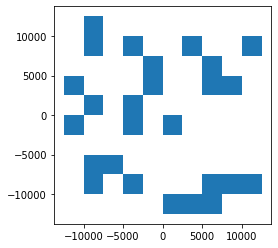

In [4]:
# pick 30 random boxes

random_30 = []
for i in range(30):
    random_30.append(random.choice(boxes))
    
boxes30 = gpd.GeoDataFrame(geometry=random_30)
boxes30.plot();    

# 2 - Create a Geoseries of the CSV file

In [5]:
# set path of the train dataset
trainpath = '/Users/pedrojunqueira/Desktop/train'

In [6]:
# create a list with the id of the stamps
trainids = os.listdir(trainpath)
len(trainids)

1863

In [7]:
commodity = 'commodities.csv'

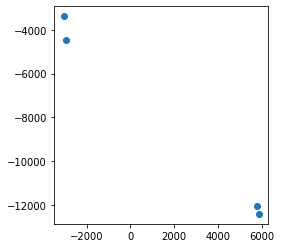

In [8]:
#deps = pd.read_csv(os.path.join(trainpath,trainids[0],commodity))
deps = pd.read_csv(os.path.join(trainpath,"47763108",commodity))
geometry = deps.apply(lambda row: Point(row['x'],row['y']), axis=1)
deps = gpd.GeoDataFrame(deps, geometry=geometry)
deps.plot();


In [9]:
deps

,stamp_id,x,y,commodity,geometry
0,47763108,-2943.373687,-4448.565017,Cu,POINT (-2943.374 -4448.565)
1,47763108,-3038.769050,-3378.388389,Zn;Pb,POINT (-3038.769 -3378.388)
2,47763108,5869.865673,-12416.639513,Mn,POINT (5869.866 -12416.640)
3,47763108,5772.979969,-12067.019114,Mn,POINT (5772.980 -12067.019)


in box (-5000.0, -5000.0, -2500.0, -2500.0) there are 2 deposits
in box (5000.0, -12500.0, 7500.0, -10000.0) there are 2 deposits


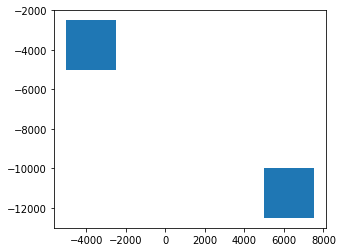

In [10]:
boxes_with_deposit = []
box_number = []
for i, box in enumerate(boxes):
    if deps['geometry'].within(box).sum():
        print(f'in box {box.bounds} there are {deps["geometry"].within(box).sum()} deposits')
        boxes_with_deposit.append(box)
        box_number.append(i+1)
        
boxesframe = gpd.GeoDataFrame(geometry=boxes_with_deposit)
boxesframe.plot();        

In [11]:
box_number

[37, 80]

# 3 - create a stamp map dictionary

In [12]:
start = datetime.now()


# import stamp geodataframe path
stamps_data = '../data/stamp_locations.geo.json'
# create geodataframe objects
stamps = gpd.read_file(stamps_data)

commodity_path = 'commodities.csv'

stamp_map = dict()
for n, train_i in enumerate(trainids):
    deps = pd.read_csv(os.path.join(trainpath,train_i,commodity_path))
    if deps.shape[0] == 0:
        stamp_id = train_i
        for i, box in enumerate(boxes):
            stamp_map[f'{stamp_id}_{i+1}'] = (i, 'none', 'none',0)
    else:
        geometry = deps.apply(lambda row: Point(row['x'],row['y']), axis=1)
        deps = gpd.GeoDataFrame(deps, geometry=geometry)
        stamp_id = train_i
        commodity = stamps[stamps['id']==train_i]['stratification_label'].values[0]
        for i, box in enumerate(boxes):
            for i, box in enumerate(boxes):
                if deps['geometry'].within(box).sum() > 0 :
                    dep_label = deps[deps['geometry'].within(box)]['commodity'].values
                    dep_label = ';'.join(dep_label)
                    dep_label = list(set(dep_label.split(";")))
                    if len(dep_label) > 1:
                        dep_label = commodity
                    else:
                        dep_label = dep_label[0]
                    stamp_map[f'{stamp_id}_{i+1}'] = (i, commodity, dep_label ,deps['geometry'].within(box).sum())
                else:
                    stamp_map[f'{stamp_id}_{i+1}'] = (i, 'none', 'none',0)
    if n%100 == 0:
        print(f'{n}/{len(trainids)} processed...')            

print(f'{n+1}/{len(trainids)} processed...')     


finish = datetime.now()
duration = finish - start
print(f'this cell ran in {duration.seconds} seconds')

0/1863 processed...
100/1863 processed...
200/1863 processed...
300/1863 processed...
400/1863 processed...
500/1863 processed...
600/1863 processed...
700/1863 processed...
800/1863 processed...
900/1863 processed...
1000/1863 processed...
1100/1863 processed...
1200/1863 processed...
1300/1863 processed...
1400/1863 processed...
1500/1863 processed...
1600/1863 processed...
1700/1863 processed...
1800/1863 processed...
1862/1863 processed...


In [142]:
len(stamp_map)
type(stamp_map)


tuple

In [ ]:
# stamp_map = dict()
# deps = pd.read_csv(os.path.join(trainpath,trainids[1858],commodity_path))
# geometry = deps.apply(lambda row: Point(row['x'],row['y']), axis=1)
# deps = gpd.GeoDataFrame(deps, geometry=geometry)
# commodity = stamps[stamps['id']==trainids[1858]]['stratification_label'].values[0]
# for i, box in enumerate(boxes):
#     for i, box in enumerate(boxes):
#         if deps['geometry'].within(box).sum() > 0 :
#             dep_label = deps[deps['geometry'].within(box)]['commodity'].values
#             dep_label = ';'.join(dep_label)
#             dep_label = list(set(dep_label.split(";")))
#             if len(dep_label) > 1:
#                 dep_label = commodity
#             else:
#                 dep_label = dep_label[0]
#             stamp_map[f'{stamp_id}_{i+1}'] = (i, commodity, dep_label ,deps['geometry'].within(box).sum())




In [ ]:
# stamp_map


# 4 - Split the raster in small 50x50 

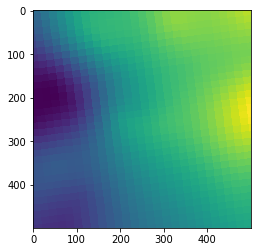

In [15]:
# now load one raster file of this stamp say bouger_gravity anomaly
tif = os.path.join(trainpath,trainids[0],'geophysics/gravity/isostatic_residual_gravity_anomaly.tif')

with rasterio.open(tif, 'r') as src:
    meta = src.meta
    data = src.read(1)

plt.imshow(data);   

In [16]:
# create a dictionary to extract geophysics file features

# open test raster file path
target_path = '/Users/pedrojunqueira/Desktop/train/75867950'

file_structure = dict()

for root, dirs, files in os.walk(target_path):
    for name in files:
        #print(os.path.join(root, name))
        ext = name.split('.')[-1]
        filename = name.split('.')[0]
        filepath = os.path.join(root, name)
        if ext == 'tif':
            first = '/'.join(filepath.split('/')[:5])
            second = '/'.join(filepath.split('/')[6:])
            file_structure[filename] = (first,second)
            file_structure[filename] = (first,second)

In [17]:
# save tiles data in a list

target_tif = file_structure['isostatic_residual_gravity_anomaly']

height = 500
width = 500
tilesheight = 50
tileswidth = 50

tiles_map = dict()
for n, train_i in enumerate(trainids):
    first, third = target_tif
    tif = os.path.join(first,train_i,third)
    rows = range(int(height/tilesheight))
    cols = range(int(width/tileswidth))
    count= 0
    for i in rows:
        for j in cols:
            with rasterio.open(tif, 'r') as src:
                w = src.read(1, window=Window(i*tileswidth, j*tilesheight, 50, 50))
                col_off = i*tileswidth
                row_off = j*tilesheight
                tiles_map[f'{train_i}_{count+1}'] = ( w , (col_off,row_off) )
                count+=1
    if n%100 == 0:
        print(f'{n}/{len(trainids)} processed...')            

print(f'{n+1}/{len(trainids)} processed...')             

0/1863 processed...
100/1863 processed...
200/1863 processed...
300/1863 processed...
400/1863 processed...
500/1863 processed...
600/1863 processed...
700/1863 processed...
800/1863 processed...
900/1863 processed...
1000/1863 processed...
1100/1863 processed...
1200/1863 processed...
1300/1863 processed...
1400/1863 processed...
1500/1863 processed...
1600/1863 processed...
1700/1863 processed...
1800/1863 processed...
1863/1863 processed...


In [18]:

print(len(tiles_map))

print(type(tiles_map))

186300
<class 'dict'>


# 5 - Create a dataset

In [19]:
# tuple (['StampID_Box#'], [Tile Data], [Strat_Label], [Commod_Labe1]) 


box_id = []
data = []
strat_label = []
comm_label = []

for key, value in stamp_map.items():
    i, strat, comm, _ = value
    box_id.append(key)
    tile_data = tiles_map.get(key)
    d, (_, _ ) = tile_data
    data.append(d)
    strat_label.append(strat)
    comm_label.append(comm)

dataset = (np.array(box_id), np.array(data)
           ,np.array(strat_label), np.array(comm_label))

In [20]:
box_id, data ,strat_label, comm_label = dataset

print(f'data shape is: {data.shape}')


data shape is: (186300, 50, 50)


In [144]:
stamp_map['82771002_1']

(0, 'none', 'none', 0)

In [148]:
len(stamp_map)


186300

In [145]:
# tuple (['StampID_Box#'], [Tile Data], [Strat_Label], [Commod_Labe1]) 
# create a dataset subset with only samples without 'none' deposits


box_id = []
data = []
strat_label = []
comm_label = []

for key, value in stamp_map.items():
    i, strat, comm, _ = value
    if strat !='none':
        box_id.append(key)
        tile_data = tiles_map.get(key)
        d, (_, _ ) = tile_data
        data.append(d)
        strat_label.append(strat)
        comm_label.append(comm)

dataset_minerals = (np.array(box_id), np.array(data)
           ,np.array(strat_label), np.array(comm_label))

In [151]:
stamp_box_id, features, labels, _ = dataset_minerals

In [155]:
# inspecting arrays shapes

print(f'stamp_box_id shape is: {stamp_box_id.shape} dtype is {stamp_box_id.dtype}')

print(f'features shape is: {features.shape}  dtype is {features.dtype}')

print(f'labels is: {labels.shape} dtype is {labels.dtype}')

stamp_box_id shape is: (3121,) dtype is <U12
features shape is: (3121, 50, 50)  dtype is float32
labels is: (3121,) dtype is <U5


# Saving dataset in a HDF5 database

In [213]:
# instatiate db object, open and have write permission
db = h5py.File('deposits_classes.hdf5', 'w')

In [214]:
# create dataset object
# define name/key, shape/dimention of the object and datatype 
data = db.create_dataset(name='features',shape=features.shape,dtype='float' )

# to add string to the database need to create a special data type str
dt = h5py.special_dtype(vlen=str)

# same process to create the dataset for string data
stamp_id = db.create_dataset('stamp_id', (3121,), dtype=dt)
label = db.create_dataset('label', (3121,), dtype=dt)

# stamp_id = db.create_dataset(name='stamp_id',(3121,),dtype=dt )
# label = db.create_dataset(name='label',(3121,),dtype=dt )


In [219]:
# load data in the database

data[:,:,:] =  features
stamp_id[:] = stamp_box_id
label[:] = labels


In [220]:
# close database
db.close()

In [2]:
# test if reading data from database
db = h5py.File('deposits_classes.hdf5', 'r')

In [3]:
db.keys()

<KeysViewHDF5 ['features', 'label', 'stamp_id']>

In [4]:
# check if data saved by loading it
db['features'][-1]
db['label'][-1]
db['stamp_id'][-1]

'42884730_56'

In [231]:
# close DB
db.close()

# Plot Boxplot of commodity distribution of mean gravity

In [21]:
set(strat_label)

{'Au', 'Cu', 'Fe', 'PGE', 'Pb', 'none', 'other'}

In [22]:
set(comm_label)

{'Ag',
 'Au',
 'Cu',
 'Fe',
 'Mn',
 'Mo',
 'Ni',
 'PGE',
 'Pb',
 'REE',
 'Sb',
 'Sn',
 'Ta',
 'U',
 'V',
 'W',
 'Zn',
 'Zr',
 'none',
 'other'}

In [23]:
# save data in a dataframe
small_box_data = {'id':box_id, 'strat':strat_label, 'comm':comm_label}
small_box = pd.DataFrame(small_box_data)
small_box

,id,strat,comm
0,82771002_1,none,none
1,82771002_2,none,none
2,82771002_3,none,none
3,82771002_4,none,none
4,82771002_5,none,none
...,...,...,...
186295,44310191_96,none,none
186296,44310191_97,none,none
186297,44310191_98,none,none
186298,44310191_99,none,none


In [25]:
# sumarize counts grouped by commodity and stratification label
small_box.groupby(['strat','comm'])['id'].count()

strat  comm 
Au     Au         1216
       Fe           40
       Mn            8
       Ni            8
       Pb            1
       Sb            2
       Sn            7
       Ta            2
       U            13
Cu     Ag            4
       Au          183
       Cu          683
       Fe           30
       Mn           27
       Ni           17
       REE           1
       Sb            2
       Sn           14
       Ta            1
       U            26
       V             1
       Zn            1
Fe     Fe          266
       Mn            4
       Sn            2
       U             5
PGE    Ag            1
       Au           58
       Cu            9
       Ni           11
       PGE         113
       Sn           13
       U             1
Pb     Pb           33
none   none     183179
other  Mn           40
       Mo            1
       Ni            2
       REE           3
       Sb            2
       Sn           33
       Ta            1
       U            3

In [59]:

small_box['strat'].value_counts(normalize=True)

none     0.983247
Au       0.006962
Cu       0.005314
other    0.001707
Fe       0.001487
PGE      0.001106
Pb       0.000177
Name: strat, dtype: float64

98% of the stamps have no deposits

In [98]:
small_box['strat'].value_counts()

none     183179
Au         1297
Cu          990
other       318
Fe          277
PGE         206
Pb           33
Name: strat, dtype: int64

In [65]:
data[0].mean()

128.52185

In [68]:
# create a mean data columns
small_box['mean'] = [i.mean() for i in data]

In [69]:
small_box

,id,strat,comm,mean
0,82771002_1,none,none,128.521851
1,82771002_2,none,none,98.456902
2,82771002_3,none,none,53.019714
3,82771002_4,none,none,21.473490
4,82771002_5,none,none,21.336618
...,...,...,...,...
186295,44310191_96,none,none,499.661011
186296,44310191_97,none,none,534.880920
186297,44310191_98,none,none,572.944458
186298,44310191_99,none,none,607.993225


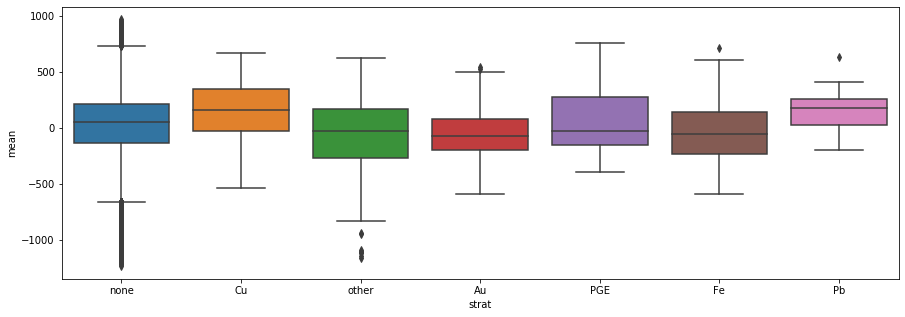

In [97]:
# plot the distribution of average per commodity
# exclude some extreme outliers only 2 datapoints in the none data
plotdata = small_box[small_box['mean']<970]
fig, ax = plt.subplots( figsize=(15,5))
sns.boxplot(x='strat',y='mean',data=plotdata, ax=ax );

In [73]:
small_box['mean'].std()

1375966209.9616272

In [74]:
small_box['mean'].mean()

3187978.5014033723

In [75]:
small_box['mean'].max()

593901191168.0

In [77]:
small_box['mean'].min()

-1237.4339599609375

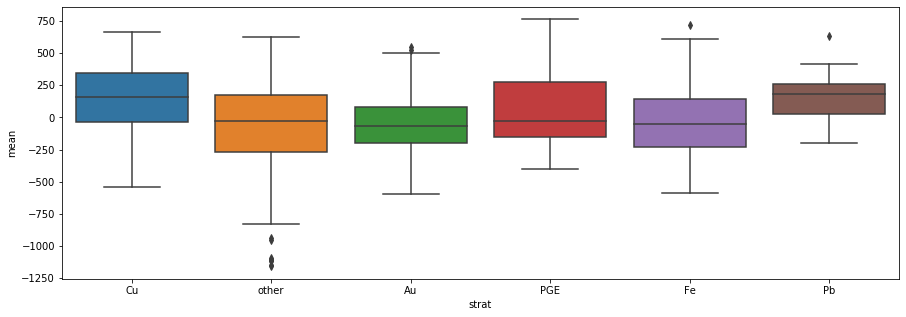

In [99]:
# plot the chart without none class

plotdata = small_box[small_box['strat']!='none']
fig, ax = plt.subplots( figsize=(15,5))
sns.boxplot(x='strat',y='mean',data=plotdata, ax=ax );

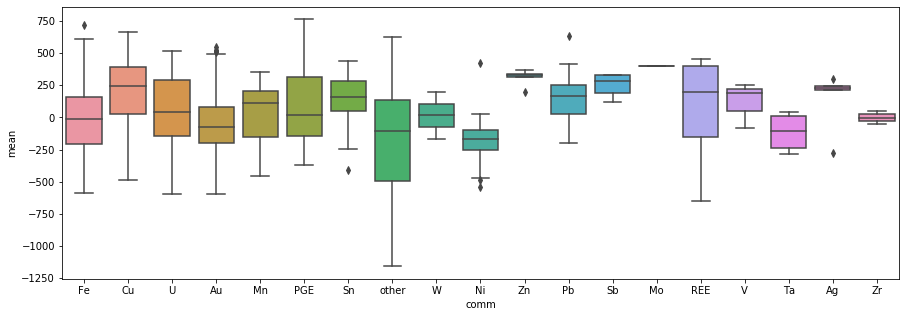

In [101]:
# plot the chart without none class but for each commodity type

plotdata = small_box[small_box['comm']!='none']
fig, ax = plt.subplots( figsize=(15,5))
sns.boxplot(x='comm',y='mean',data=plotdata, ax=ax );

In [102]:
small_box['comm'].value_counts()

none     183179
Au         1457
Cu          692
Fe          336
other       193
PGE         113
Mn           79
U            77
Sn           69
Ni           38
Pb           34
Sb            6
Ag            5
Zn            5
REE           4
Ta            4
V             3
W             3
Zr            2
Mo            1
Name: comm, dtype: int64

1


In [116]:

count=0
for i in range(10000*1000):
    count+=1
    

In [111]:
duration.seconds

0